# Predicting Civil War Onset : What about other prediction model ? Whcich of them is the most relevant ?

## Abstract

At the end of their paper, the authors state that "the analyses [...] show that Random Forests offers superior predictve power compared to several forms of logistic regression". Then, when we read the paper, we asked ourselves : why the authors only used Logistic Regression and Random Forest methods ?

In this extension we will therefore try to compare Random Forest and Logistic Regression to some other methods as Support Vector Machine (SVM) and Least Square.
In our analysis, we will try to compare the accuracy of our models with the models of the paper by comparing the AUCs, we will also try to compare the robustness and the complexity of all the methods to highlight the more efficient one.

Finally, we will try to pinpoint the more important features when using our models. As a result, we will try to compare these features with the ones from Random Forests and then identify the most important ones in average.

## Table of content

In [ ]:
# Importing libraries for data manipulation
import numpy as np
import pandas as pd

# Import of libraries for the visualization of results
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Importation of libraries for model training.
from sklearn import linear_model, svm
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor

# Import of libraries for the analysis of the results
from sklearn.metrics import mean_squared_error, auc, roc_curve
from sklearn.model_selection import cross_val_predict, cross_val_score,train_test_split

# 0. Data pre-processing

In this project, we chose to compare different training models. One of the objectives is to compare the results obtained in this project with the models implemented in the paper. Thus, we have chosen to keep the data provided in the paper. Thus, in this project, we will use the ***Civil War Data (CWD)*** dataset. 

This dataset is taken from the Civil War Data (CWD) and contains nearly **286 prediction variables**.
Each row corresponds to a country-year and contains the values of the 286 variables.
We can see that the values are quite different from one column to another.

Indeed, some columns have continuous values, other columns have discrete values (such as a number of years),
and finally, columns with binary values $\{0, 1\}$.
So we have a table composed of **7141 country-years** and **286 variables**.

In this study, we will keep only **90 of these variables**. These variables are the same variables used in the paper models. We also use these data since they are the most consistent with the results we are looking for.

In [108]:
# Loading data contained in the csv file.
data = pd.read_csv('SambnisImp.csv')

# Filtering of the initial table to keep only the 90 useful variables.
data_filtred = data[["warstds", "ager", "agexp", "anoc", "army85", "autch98", "auto4",
    "autonomy", "avgnabo", "centpol3", "coldwar", "decade1", "decade2",
    "decade3", "decade4", "dem", "dem4", "demch98", "dlang", "drel", "durable",
    "ef", "ef2", "ehet", "elfo", "elfo2", "etdo4590", "expgdp", "exrec",
    "fedpol3", "fuelexp", "gdpgrowth", "geo1", "geo2", "geo34", "geo57",
    "geo69", "geo8", "illiteracy", "incumb", "infant", "inst", "inst3", "life",
    "lmtnest", "ln_gdpen", "lpopns", "major", "manuexp", "milper", "mirps0",
    "mirps1", "mirps2", "mirps3", "nat_war", "ncontig", "nmgdp", "nmdp4_alt",
    "numlang", "nwstate", "oil", "p4mchg", "parcomp", "parreg", "part",
    "partfree", "plural", "plurrel", "pol4", "pol4m", "pol4sq", "polch98",
    "polcomp", "popdense", "presi", "pri", "proxregc", "ptime", "reg",
    "regd4_alt", "relfrac", "seceduc", "second", "semipol3", "sip2", "sxpnew",
    "sxpsq", "tnatwar", "trade", "warhist", "xconst"]]

# Display of the first lines of the filtered table
data_filtred.head()

,warstds,ager,agexp,anoc,army85,autch98,auto4,autonomy,avgnabo,centpol3,...,seceduc,second,semipol3,sip2,sxpnew,sxpsq,tnatwar,trade,warhist,xconst
0,0,34.461765,8.510845,0,129472.9042,0,3.925812,0.005151,0.432955,1,...,43.770298,0.253,0.058441,0.46176,0.158275,0.052989,0.443259,72.881375,0,3.995912
1,0,34.346348,8.478997,0,129413.0225,0,10.000000,0.000000,0.045052,1,...,43.588363,0.253,0.000000,0.00000,0.158321,0.052663,1.000000,72.900089,0,1.000000
2,0,77.000000,8.481015,0,130431.0145,0,10.000000,0.000000,0.030034,1,...,43.538181,0.253,0.000000,0.00000,0.158425,0.052891,2.000000,72.962880,0,1.000000
3,0,78.000000,8.451628,0,126781.6866,0,10.000000,0.000000,0.022526,1,...,43.490005,0.253,0.000000,0.00000,0.159006,0.052902,2.000000,73.102449,0,1.000000
4,0,79.000000,8.500172,0,130979.2470,0,10.000000,0.000000,0.022526,1,...,43.602238,0.253,0.000000,0.00000,0.158074,0.052706,2.000000,72.850389,0,1.000000


In [109]:
# Defining the corresponding output values and feature vectors for training the different models. The output vector is 
# similar for each model while the feature vectors are different.
# The output binary variable signalling the onset of civil war. 1 corresponds to a recorded civil war while 0 corresponds to otherwise
y = data_filtred['warstds'] 

# All the variables can be used for training except the target variable which is warstds
X = data_filtred.drop(['warstds'], axis=1)

X.head()

,ager,agexp,anoc,army85,autch98,auto4,autonomy,avgnabo,centpol3,coldwar,...,seceduc,second,semipol3,sip2,sxpnew,sxpsq,tnatwar,trade,warhist,xconst
0,34.461765,8.510845,0,129472.9042,0,3.925812,0.005151,0.432955,1,1,...,43.770298,0.253,0.058441,0.46176,0.158275,0.052989,0.443259,72.881375,0,3.995912
1,34.346348,8.478997,0,129413.0225,0,10.000000,0.000000,0.045052,1,1,...,43.588363,0.253,0.000000,0.00000,0.158321,0.052663,1.000000,72.900089,0,1.000000
2,77.000000,8.481015,0,130431.0145,0,10.000000,0.000000,0.030034,1,1,...,43.538181,0.253,0.000000,0.00000,0.158425,0.052891,2.000000,72.962880,0,1.000000
3,78.000000,8.451628,0,126781.6866,0,10.000000,0.000000,0.022526,1,1,...,43.490005,0.253,0.000000,0.00000,0.159006,0.052902,2.000000,73.102449,0,1.000000
4,79.000000,8.500172,0,130979.2470,0,10.000000,0.000000,0.022526,1,1,...,43.602238,0.253,0.000000,0.00000,0.158074,0.052706,2.000000,72.850389,0,1.000000


#### Missing data ?
At first glance, the data seems to be complete. However, if there are missing data,
we will have to process them in order to be able to correctly carry out our predictions. 

As shown below, there are no missing values.

In [110]:
number_missing_data = len(data_filtred[data_filtred.isna().any(axis=1)])
print(f"There is {number_missing_data} missing data")

There is 0 missing data


#### Standardization
With CWD, there are large differences in values.

Some models will need standardized values because standardization will allow to **accelerate convergence** (which does not have a big impact unless the dataset is very large) and will allow a **better interpretation of the coefficients** and their importance.

We will use standardization performing the following calculation:

$$ X' = \frac{\textbf{X} - \mu}{\sigma}$$

$\mu$ is the **mean of the feature** values and
$\sigma$ is the **standard deviation** of the feature values.

***Note***: No standardization for binary variables that have $\{0, 1\}$ as a set.

In [111]:
"""
For each variable (col in df.columns) we will standardize all the values.
To do this we remove the average from each value of the column: df[col].mean()
Then we divide by the standard deviation: df[col].std()

Each column will be standardized, except for binary variables.
(which have as a set of values: {0, 1}).
"""
def standardize(df):
    # We select a column
    for col in df.columns:
        # We check if it is a binary variable
        if df[col].nunique() > 10:
            # If it is not a binary variable,
            # then standardization is achieved
            df[col] = (df[col] - df[col].mean())/df[col].std()

    # Returns the table with all
    # standardized values, column by column
    return df

#### Categorical Data
Thus, as explained above, we are not going to standardize categorical data. The code below allows you to visualize the categorical data and their set of values. Globally, these variables are binary variables, such as **dem** which is equal to 1 if the country is a democracy and 0 otherwise.

In [112]:
# Find categorical data
def is_categ(df):
    for col in df.columns:
        # if the cardinal of the set of values of a vector is less than 10, 
        # it is considered a categorical variable.
        if len(set(df[col].values)) < 10:
            print(col, '     \t:\t', set(df[col].values))
            
is_categ(data_filtred)

warstds      	:	 {0, 1}
anoc      	:	 {0, 1}
centpol3      	:	 {0, 1}
coldwar      	:	 {0, 1}
decade1      	:	 {0, 1}
decade2      	:	 {0, 1}
decade3      	:	 {0, 1}
decade4      	:	 {0, 1}
dem      	:	 {0, 1}
incumb      	:	 {0, 1}
inst      	:	 {0, 1, 2, 3}
major      	:	 {0, 1}
nat_war      	:	 {0, 1}
oil      	:	 {0, 1}
partfree      	:	 {0, 1}
presi      	:	 {0, 1}
warhist      	:	 {0, 1}


# 1. Least Square Method

In the case of a dataset composed of continuous and categorical variables, it seems obvious that the least square method is not the most suitable method. Thus, it seemed interesting to analyze the behavior of this method in front of this non-linear dataset. Indeed, it is legitimate to wonder to what extent the least square method is wrong. Can it, in spite of everything, give coherent results ?

In order to carry out this first study of the least square model. We are going to start by naively carrying out a regression with the 90 initial variables. Then, we will be able to evaluate the most influential data concerning this model. Indeed, the p-value of the variables will allow us to establish the list of variables that allow the best prediction. Finally, we will perform a new training of the model with the significant variables.

To summarize, here are the three steps of this first part:
- Step 1 : Try the method with the 90 variables (sklearn)
- Step 2 : Try to find significant variables (statmodels)
- Step 3 : Retry the linear regression method with significant variables (sklearn)

### Step 1 : Try the method with the 90 variables (sklearn)
In this first step, the 90 previously selected variables are used and then the model is trained with the LinearRegression function.

#### Features and target selection

In [121]:
# target vector y for regression
y = data['warstds']

# features
X = data_filtred
X = X.drop('warstds',axis=1)

***Note***: *warstds* corresponds to the onset of a civil war. If the value is 1, then this line is a civil war outbreak, otherwise the value is 0. This vector is the target vector, so it makes sense to remove this vector from the features.

In [122]:
# assignment of the model
model = linear_model.LinearRegression()

# assignment of the title of the graph
graph_title = "Least square"

# Predict the probabilities with a cross validation
y_pred = cross_val_predict(model, X,y, cv=10)

# Compute the False Positive Rate and True Positive Rate
fpr, tpr, _ = roc_curve(y, y_pred[:])

#### Plot the ROC curves

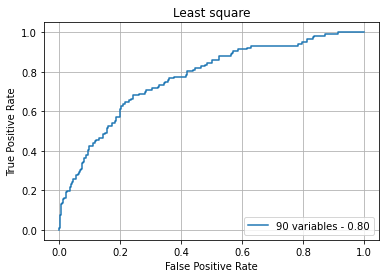

In [123]:
# Stores the ROC curve plot for each model.
plt.plot(fpr, tpr, label="90 variables" + " - {:.2f}".format(auc_score))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# Drawing ROC curves with the legend
plt.legend(loc='lower right')
# Adding the title according to the selected regression type
plt.title(graph_title)
plt.grid()
plt.show()

### Accuracy
In order to be able to validate or not the model, it is also important to evaluate the accuracy. Knowing that the accurary can vary a lot depending on the way the dataset is divided, the accuracy is averaged over 500 simulations.

In [134]:
Nsim = 500
accuracy = []
for i in range(Nsim):
    X_train, X_test, y_train, y_test = train_test_split(X_newdata, y, test_size=0.2)
    model.fit(X_train,y_train)
    accuracy.append(model.score(X_test,y_test))
print(np.array(accuracy).mean()*100,'%')

2.5111488059265366 %


### Conclusion of Step 1
A faire

### Step 2 : Find relevant variables
In this second step, the statmodel library is used in order to have a good visualization of the importance of the data. Indeed, statmodel allows us to obtain the p-values of each variable, as well as the coefficients of these variables. We can then select the variables that best train the model.

In [124]:
# Declares the model
import statsmodels.formula.api as smf

mod = smf.ols(formula='warstds ~ + ager + agexp + C(anoc) + army85 + autch98 + auto4 + \
                              autonomy + avgnabo + C(centpol3) + C(coldwar) + C(decade1) + C(decade2) + \
                              C(decade3) + C(decade4) + C(dem) + dem4 + demch98 + dlang + drel + durable + \
                              ef + ef2 + ehet + elfo + elfo2 + etdo4590 + expgdp + exrec + fedpol3 + \
                              fuelexp + gdpgrowth + geo1 + geo2 + geo34 + geo57 + geo69 + geo8 + \
                              illiteracy + C(incumb) + infant + inst + inst3 + life + lmtnest + \
                              ln_gdpen + lpopns + C(major) + manuexp + milper + mirps0 + mirps1 + \
                              mirps2 + mirps3 + C(nat_war) + ncontig + nmgdp + nmdp4_alt + numlang + \
                              nwstate + C(oil) + p4mchg + parcomp + parreg + part + C(partfree) + plural + \
                              plurrel + pol4 + pol4m + pol4sq + polch98 + polcomp + popdense + pri + \
                              proxregc + ptime + reg + regd4_alt + relfrac + seceduc + second + C(presi) + \
                              semipol3 + sip2 + sxpnew + sxpsq + tnatwar + trade + C(warhist) + xconst', data=data_filtred)

# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()

# Print thes summary output provided by the library.
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:                warstds   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     4.404
Date:                Wed, 16 Dec 2020   Prob (F-statistic):           1.81e-37
Time:                        17:54:27   Log-Likelihood:                 4824.1
No. Observations:                7140   AIC:                            -9472.
Df Residuals:                    7052   BIC:                            -8867.
Df Model:                          87                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.1171      0.074  

In [125]:
# feature names
variables = res.params.index

# coefficients
coefficients = res.params.values

# p-values
p_values = res.pvalues

# standard errors
standard_errors = res.bse.values

#sort them all by coefficients
l1, l2, l3, l4 = zip(*sorted(zip(coefficients[1:], variables[1:], standard_errors[1:], p_values[1:])))

### Selection of the most significant variables

In [126]:
# Filter with P value
new_data = []

for i in range(len(l4)):
    # select the variable if its p-value is lower than 5%
    if l4[i] < 0.05:
        new_data.append(l2[i])
new_data

['gdpgrowth',
 'sxpnew',
 'second',
 'proxregc',
 'C(presi)[T.1]',
 'tnatwar',
 'parreg',
 'manuexp',
 'popdense',
 'agexp',
 'auto4',
 'C(decade4)[T.1]',
 'C(nat_war)[T.1]',
 'inst3',
 'mirps0',
 'nwstate']

### Conclusion of Step 2
A faire

### Step 3 : Retry the linear regression method with significant variables (sklearn)
In this last part, we will reexamine the model but with the most significant variables. Thus, the objective is to observe if the results given by this new model are more accurate.

In [127]:
model = linear_model.LinearRegression()
graph_title = "Least square"

In [128]:
new_data = ['gdpgrowth', 'sxpnew', 'second', 'proxregc', 'presi', 
             'tnatwar', 'parreg', 'manuexp', 'popdense', 'agexp', 'auto4', 
             'decade4', 'nat_war', 'inst3', 'mirps0', 'nwstate']

X_newdata = data[new_data]
y = data['warstds']

In [129]:
# Predict the probabilities with a cross validation
y_pred = cross_val_predict(model, X_train, y_train, cv=10)

# Compute the False Positive Rate and True Positive Rate
fpr, tpr, _ = roc_curve(y_train, y_pred[:])

# Compute the area under the fpt-tpf curve
auc_score = auc(fpr, tpr)

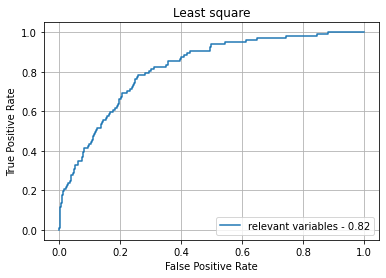

In [131]:
# Stores the ROC curve plot for each model.
plt.plot(fpr, tpr, label="relevant variables" + " - {:.2f}".format(auc_score))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

# Drawing ROC curves with the legend
plt.legend(loc='lower right')
# Adding the title according to the selected regression type
plt.title(graph_title)
plt.grid()
plt.show()

### Accuracy
In order to be able to validate or not the model, it is also important to evaluate the accuracy. Knowing that the accurary can vary a lot depending on the way the dataset is divided, the accuracy is averaged over 500 simulations.

In [135]:
Nsim = 500
accuracy = []
for i in range(Nsim):
    X_train, X_test, y_train, y_test = train_test_split(X_newdata, y, test_size=0.2)
    model.fit(X_train,y_train)
    accuracy.append(model.score(X_test,y_test))
print(np.array(accuracy).mean()*100,'%')

2.496971547738277 %


### Conclusion and results analysis : Least Square Method 

# 2. SVM
Fitting a SVM to the dataset for predicting the onset of civil war. Instead of binary prediction, we will fit a SVM which outputs the 
probability of belonging to a class so that we can plot a ROC curve by varying the threshold probability and obtain the respective AUC. 

There are a total of 74 continuous features out of 91 total fields and rest 17 are categorical variables

In [133]:
# Standardising all the continuous features for better scaling of variables
X_std = X.copy()
X_std = standardize(X_std)
X_std

,ager,agexp,anoc,army85,autch98,auto4,autonomy,avgnabo,centpol3,coldwar,...,seceduc,second,semipol3,sip2,sxpnew,sxpsq,tnatwar,trade,warhist,xconst
0,0.011565,-0.075864,0,-0.097323,0.016433,-0.005731,-0.018215,-0.053497,1,1,...,0.076855,0.919162,-0.007550,0.026881,0.094095,0.052437,-0.139284,0.107157,0,0.033310
1,0.008046,-0.079254,0,-0.097473,0.016433,1.775804,-0.082597,-1.315951,1,1,...,0.069821,0.919162,-0.287012,-1.219573,0.094547,0.049137,0.509491,0.107596,0,-1.298861
2,1.308743,-0.079039,0,-0.094927,0.016433,1.775804,-0.082597,-1.364826,1,1,...,0.067881,0.919162,-0.287012,-1.219573,0.095567,0.051447,1.674799,0.109070,0,-1.298861
3,1.339237,-0.082167,0,-0.104053,0.016433,1.775804,-0.082597,-1.389263,1,1,...,0.066018,0.919162,-0.287012,-1.219573,0.101303,0.051559,1.674799,0.112345,0,-1.298861
4,1.369731,-0.077000,0,-0.093556,0.016433,1.775804,-0.082597,-1.389263,1,1,...,0.070357,0.919162,-0.287012,-1.219573,0.092107,0.049569,1.674799,0.106430,0,-1.298861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7135,-0.093999,-0.262238,0,-0.306074,0.016433,0.602620,-0.082597,0.334757,1,0,...,0.213322,0.415169,-0.007124,-0.254582,0.259141,-0.174152,-0.655817,0.250157,0,-0.409535
7136,-0.063505,-0.170693,0,-0.306074,0.016433,0.602620,-0.082597,0.334757,1,0,...,0.213322,0.415169,-0.006284,-0.254582,0.452436,-0.100702,-0.655817,0.103778,0,-0.409535
7137,-0.033010,0.145460,0,-0.306074,0.016433,0.602620,-0.082597,0.334757,1,0,...,0.213322,0.415169,-0.006889,-0.254582,0.097356,0.050272,-0.655817,0.256251,0,-0.409535
7138,-0.002516,-0.075457,0,-0.306074,-1.380375,0.602620,-0.082597,0.334757,1,0,...,0.213322,0.415169,-0.006289,-0.254582,0.090076,0.049652,-0.655817,0.106613,0,-0.409535


In [149]:
# fitting a svm model with default parameters
model_Svm = svm.SVC(probability = True, gamma = 'scale')
# Training the model by cross validation. Employing cross validation is preferable to just training on the whole
# dataset and predicting on the same dataset as the latter approach entails overfitting. 

# Predict the probabilities with a cross validation
y_pred3 = cross_val_predict(model_Svm, X_std, y, cv=5,method='predict_proba')
# Compute the False Positive Rate and True Positive Rate
fpr3, tpr3, _ = roc_curve(y, y_pred3[:,1])
# Compute the area under the fpr-tpr curve
auc_score3 = auc(fpr3, tpr3)

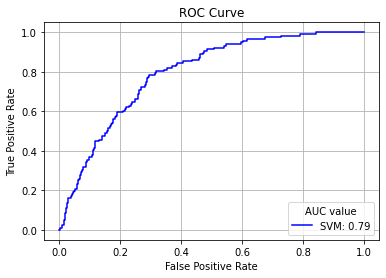

In [150]:
plt.plot(fpr3, tpr3, 'b', label ="SVM: " + str(round(auc_score3,2)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve");
plt.legend(loc="lower right",title="AUC value")
plt.grid()
plt.show()

# 3. Neural Networks
We will try to use a neural network to classify the dataset according to the variables. As neural networks have been shown to have a higher accuracy than the traditional methods, it is expected that this should lead to a better AUC

In [152]:
mlp = MLPClassifier()
# Training the model by cross validation. Employing cross validation is preferable to just training on the whole
# dataset and predicting on the same dataset as the latter approach entails overfitting. 

# Predict the probabilities with a cross validation
y_pred2 = cross_val_predict(mlp, X_std, y, cv=5, method="predict_proba")
# Compute the False Positive Rate and True Positive Rate
fpr2, tpr2, _ = roc_curve(y, y_pred2[:, 1])
# Compute the area under the fpr-tpr curve
auc_score2 = auc(fpr2, tpr2)

C:\Users\redaa\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\redaa\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


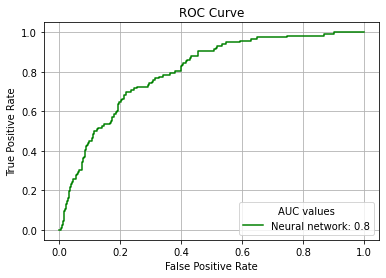

In [153]:
plt.plot(fpr2, tpr2, 'g', label ="Neural network: " + str(round(auc_score2,2)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve");
plt.legend(loc="lower right",title="AUC values")
plt.grid()
plt.show()

# 4. Bayes classifier
We also try to implement the simplest method of classification, bayes classifier, to benchmark the accuracy of other methods

In [157]:
model_naive = GaussianNB()

# Training the model by Fearon and laitin by cross validation. Employing cross validation is preferable to just training on the whole
# dataset and predicting on the same dataset as the latter approach entails overfitting. 

# Predict the probabilities with a cross validation
y_pred = cross_val_predict(model_naive, X_std, y, cv=5, method="predict_proba")
# Compute the False Positive Rate and True Positive Rate
fpr1, tpr1, _ = roc_curve(y, y_pred[:, 1])
# Compute the area under the fpr-tpr curve
auc_score = auc(fpr1, tpr1)

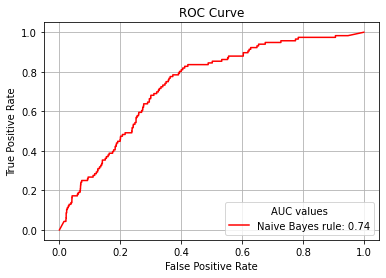

In [156]:
plt.plot(fpr1, tpr1, 'r', label ="Naive Bayes rule: " + str(round(auc_score,2)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve");
plt.legend(loc="lower right",title="AUC values")
plt.grid()
plt.show()

# 5. Analysis of results

# 6. Conclusion